In [1]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 클래스 이름
classes = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']

# CIFAR-10 테스트셋 불러오기
transform = transforms.ToTensor()
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# 이미지 출력 함수
def show_image(idx):
    image, label = testset[idx]
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Original Label: {classes[label]} (Index: {idx})")
    plt.axis('off')
    plt.show()

Matplotlib is building the font cache; this may take a moment.


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


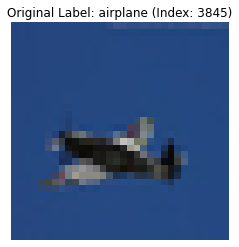

In [4]:
idx = 3845
show_image(idx)

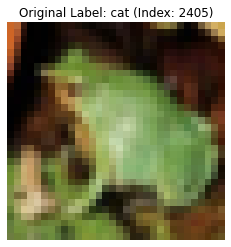

In [6]:
show_image(2405)

In [8]:
!pip install keras-tuner

     |████████████████████████████████| 129 kB 8.1 MB/s            


In [10]:
#Step 1: 모델 빌더 함수 정의
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    
    # 첫 번째 Conv 레이어
    model.add(layers.Conv2D(
        filters=hp.Choice('conv1_filters', [16, 32, 64]),
        kernel_size=3,
        activation='relu',
        input_shape=(32, 32, 3),
        padding='same'))
    
    model.add(layers.AveragePooling2D())
    model.add(layers.BatchNormalization())
    
    # 두 번째 Conv 레이어
    model.add(layers.Conv2D(
        filters=hp.Choice('conv2_filters', [32, 64, 128]),
        kernel_size=3,
        activation='relu',
        padding='valid'))
    
    model.add(layers.AveragePooling2D())
    model.add(layers.BatchNormalization())
    
    model.add(layers.Flatten())
    
    # Dense Layer
    model.add(layers.Dense(
        units=hp.Choice('dense_units', [128, 256, 512]),
        activation='relu'))
    
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model


In [11]:
#Step 2: KerasTuner로 하이퍼파라미터 튜닝
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='my_dir',
    project_name='cifar10_tuning')


In [12]:
#Step 3: CIFAR-10 데이터로 튜닝 시작
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

tuner.search(x_train, y_train,
             epochs=10,
             validation_split=0.2,
             verbose=1)

Trial 5 Complete [00h 00m 51s]
val_accuracy: 0.7189000248908997

Best val_accuracy So Far: 0.7192999720573425
Total elapsed time: 00h 05m 03s


In [13]:
#Step 4: 최적 모델로 학습 & 저장
best_hp = tuner.get_best_hyperparameters(1)[0]

# 최적 하이퍼파라미터로 새 모델 생성
model = build_model(best_hp)

# 재학습 (전체 데이터 사용)
model.fit(x_train, y_train, epochs=10, validation_split=0.1)

# SavedModel 형식으로 저장
model.save('saved_cifar10_model')

Epoch 1/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.4945 - accuracy: 0.4823 - val_loss: 1.1980 - val_accuracy: 0.5644
Epoch 2/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.1124 - accuracy: 0.6101 - val_loss: 0.9927 - val_accuracy: 0.6568
Epoch 3/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.9440 - accuracy: 0.6708 - val_loss: 0.9621 - val_accuracy: 0.6668
Epoch 4/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.8322 - accuracy: 0.7105 - val_loss: 0.8379 - val_accuracy: 0.7084
Epoch 5/10
1407/1407 [==============================] - 5s 4ms/step - loss: 0.7402 - accuracy: 0.7409 - val_loss: 0.8575 - val_accuracy: 0.7204
Epoch 6/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.6589 - accuracy: 0.7705 - val_loss: 0.8887 - val_accuracy: 0.7112
Epoch 7/10
1407/1407 [==============================] - 6s 4ms/step - loss: 0.5860 - accuracy: 0.7964 - val_loss: 1.0071 - val_accuracy: